<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C8_Spatial_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quadtrees

Imports needed for the code to run:


In [79]:
from typing import List, Tuple
from math import sqrt
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

A few helper functions:
* approx_equal: to determine based on floating point precision if two points are equal
* euclidean_dist: to calculate the Euclidean dist between two points

In [80]:
# threshold to be set based on desired numerical precision.
threshold = 0.0

def approx_equal(x1: float, y1: float, x2: float, y2: float) -> bool:
    '''
    Returns True if both points are wihin a threshold distance in both dimensions.
    '''
    if abs(x1 - x2) > threshold:
        return False
    if abs(y1 - y2) > threshold:
        return False
    return True

def euclidean_dist(x1: float, y1: float, x2: float, y2: float) -> float:
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

Point class used to represent a point, identified by x and y coordinates.

In [81]:
class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

A QuadTreeNode class used to represent a node in a QuadTree. A node can be an internal node or a leaf node.
An internal node has a maximum of 4 children nodes.
A leaf node has no childrens and instead has a list of the points contained within the node.
Each node has boundaries for the points contained (x_min - x_max and y_min - y_max) as well as the number of points contained (in itself if it's a leaf or the total of its children if it's an internal node).

In [82]:
class QuadTreeNode:
    def __init__(self, x_min: float, x_max: float, y_min: float, y_max: float):
        self.is_leaf = True
        self.num_points = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        # QuadTreeNode childrens (maximum of 4) only if it's not a leaf
        self.children = [[None for _ in range(2)] for _ in range(2)]
        # List of internal Points (if it's a leaf).
        self.points = []

    def QuadTreeNodeInsert(self, x: float, y: float) -> None:
        '''
        Adds a new point to the QuadTreeNode by traversing the tree to find
        the new point location. Ending up at a leaf node adds the point there.
        Ending up at an internal node created the necessary node there.
        '''
        # Increment the number of points with the new point being added
        self.num_points += 1

        # Determine into which child bin the point should go.
        # We only use 4 bins, so xbin and ybin can only be (0, 1).
        x_bin_size = (self.x_max - self.x_min) / 2
        y_bin_size = (self.y_max - self.y_min) / 2
        xbin = int((x - self.x_min) / x_bin_size)
        ybin = int((y - self.y_min) / y_bin_size)

        # Add the point to the correct child.
        if not self.is_leaf:
            # Check first if the child exists and if not create it
            if self.children[xbin][ybin] == None:
                self.children[xbin][ybin] = QuadTreeNode(
                    self.x_min + xbin * x_bin_size,
                    min(self.x_min + (xbin + 1) * x_bin_size, self.x_max),
                    self.y_min + ybin * y_bin_size,
                    min(self.y_min + (ybin + 1) * y_bin_size, self.y_max)
                )
            self.children[xbin][ybin].QuadTreeNodeInsert(x, y)
            return

        # Add the point to a leaf node and split if needed.
        self.points.append(Point(x, y))

        # Check if conditions for a split are met:
        #  1. Do we have enough points to justify a split? (i.e. sufficient distinct points)
        #  2. Are the spatial bounds large enough to justify a split? (i.e. have we reached the min partition size)
        #  3. Have we hit our maximum spatial depth? (i.e have we reached the max desired tree depth)

        # For simplicity sake we only check here if we have more than one point.
        if len(self.points) > 1:
            # Mark the node as no longer a leaf.
            self.is_leaf = False
            # For each point insert it into the proper quadnode childrens.
            for pt in self.points:
                self.QuadTreeNodeInsert(pt.x, pt.y)
            # Correct the num_points to avoid double-counting the re-inserted points
            # due to the counter increment at the beginning of QuadTreeInsert.
            self.num_points -= len(self.points)
            # Clear the list of points since this is now an internal node.
            self.points = []

    def QuadTreeNodeCollapse(self) -> List[Point]:
        '''
        Helper method to collapse a node that no longer meets the splitting criteria.
        Returns a list with all the subtree points.
        '''
        # First check if the node is a leaf and then directly return the list of points.
        if self.is_leaf:
            return self.points

        # If the node is internal then aggregate the points from each child.
        # Call recursively QuadTreeNodeCollapse on each non-null children.
        for i in (0, 1):
            for j in (0, 1):
                if self.children[i][j] != None:
                    sub_pts = self.children[i][j].QuadTreeNodeCollapse()
                    self.points += sub_pts
                    self.children[i][j] = None

        # Set the node as leaf (no more childrens)
        self.is_leaf = True
        return self.points

    def QuadTreeNodeDelete(self, x: float, y: float) -> bool:
        '''
        The function deletes a point identified by x and y by recursively
        going down the tree. When it reaches a leaf it deletes the point
        if it exists and then returns up the tree by collapsing nodes as needed.
        Returns True if the point was deleted.
        '''
        # Base condition for recursive calls: we have reached a leaf node.
        if self.is_leaf:
            # Iterate through the list of points and check if any matches
            # the target point.
            for point in self.points:
                if approx_equal(point.x, point.y, x, y):
                    # Remove the point from the list, decrements the count of points
                    # for this node and return True to indicate a succesful deletion.
                    self.points.remove(point)
                    self.num_points -= 1
                    return True
            # There is no matching point in this leaf.
            return False

        # Determine into which child bin the point to be removed would go.
        x_bin_size = (self.x_max - self.x_min) / 2
        y_bin_size = (self.y_max - self.y_min) / 2
        xbin = int((x - self.x_min) / x_bin_size)
        ybin = int((y - self.y_min) / y_bin_size)

        # Check if the correct child exists.
        if self.children[xbin][ybin] == None:
            return False

        # Recursively call QuadTreeNodeDelete on this child.
        if self.children[xbin][ybin].QuadTreeNodeDelete(x, y):
            # The code has deleted a point from one of the children nodes
            # so update the count of points
            self.num_points -= 1

            # Check if the child is empty and if so delete the child node.
            if self.children[xbin][ybin].num_points == 0:
                self.children[xbin][ybin] = None

            # Collapse the node if it no longer meets the split conditions to be an internal node.
            # For simplicity sake the split conditions only assume more than
            # one point.
            if self.num_points <= 1:
                self.points = self.QuadTreeNodeCollapse()
            # Indicate deletion was succesful.
            return True
        # At this point the recursive calls have not deleted any node.
        return False

    def MinDist(self, x: float, y: float) -> float:
        '''
        Helper function to compute the distance from the target point (x,y) to a node.
        '''
        x_dist = 0.0
        if x < self.x_min:
            x_dist = self.x_min - x
        if x > self.x_max:
            x_dist = x - self.x_max

        y_dist = 0.0
        if y < self.y_min:
            y_dist = self.y_min - y
        if y > self.y_max:
            y_dist = y - self.y_max

        return sqrt(x_dist**2 + y_dist**2)

    def QuadTreeNodeNearestNeighbor(self, x: float, y: float, best_dist: float) -> Point:
        '''
        Recursive search for nearest neighbor to our target point (x, y).
        best_dist represents the best distance so far and is used for our pruning logic.
        If the minimum distance to the current node is greater than the best distance
        so far then terminate this search branch.
        Returns a point that is closer than best_dist or None otherwise.
        '''
        # Prune if the node is too far away.
        if self.MinDist(x, y) >= best_dist:
            return None

        best_candidate = None

        # If we are in a leaf, search the points.
        if self.is_leaf:
            for current in self.points:
                dist = euclidean_dist(x, y, current.x, current.y)
                if dist < best_dist:
                    best_dist = dist
                    best_candidate = current
            return best_candidate

        # Recursively check all 4 children starting with the closest.
        x_bin_size = (self.x_max - self.x_min) / 2
        y_bin_size = (self.y_max - self.y_min) / 2
        xbin = int((x - self.x_min) / x_bin_size)
        if xbin < 0:
            xbin = 0
        if xbin > 1:
            xbin = 1

        ybin = int((y - self.y_min) / y_bin_size)
        if ybin < 0:
            ybin = 0
        if ybin > 1:
            ybin = 1

        # Recursively explore the non-null children.
        for i in (xbin, (xbin+1) % 2):
            for j in (ybin, (ybin+1) % 2):
                if self.children[i][j] != None:
                    quad_best = self.children[i][j].QuadTreeNodeNearestNeighbor(x, y, best_dist)
                    if quad_best != None:
                        # We have found a closer point so update best_candidate and best_dist
                        best_candidate = quad_best
                        best_dist = euclidean_dist(x, y, quad_best.x, quad_best.y)
        # best_candidate will be None if no point closer than best_dist has been found.
        return best_candidate

A QuadTree class to represent a quad tree. Each quad tree consists of an initialized QuadTreeNode root.

In [83]:
class QuadTree:
    def __init__(self, x_min: float, x_max: float, y_min: float, y_max: float):
        self.root = QuadTreeNode(x_min, x_max, y_min, y_max)

    def QuadTreeInsert(self, x: float, y: float) -> bool:
        '''
        Inserts a new point defined by x and y into the QuadTree.
        It checks that the inserted point falls within the quadtree bounds.
        Returns False if the point is out of range.
        '''
        if x < self.root.x_min or x > self.root.x_max:
            return False
        if y < self.root.y_min or y > self.root.y_max:
            return False
        self.root.QuadTreeNodeInsert(x, y)
        return True

    def QuadTreeDelete(self, x: float, y: float) -> bool:
        '''
        Deletes a point from the QuadTree by checking if the point lies
        in the bounds of the QuadTree and then recursively calling the delete
        function of the nodes.
        Returns True if a point was deleted.
        '''
        if x < self.root.x_min or x > self.root.x_max:
            return False
        if y < self.root.y_min or y > self.root.y_max:
            return False
        return self.root.QuadTreeNodeDelete(x, y)

    def QuadTreeNearestNeighbor(self, x: float, y: float) -> Point:
        '''
        Return the nearest neighbor in the tree for our target point (x, y).
        '''
        # Do not check if the target point falls within the bounds of the tree.
        # This can be used to find neighbors for points that fall outside the tree.
        # Start with best_dist as Infinity.
        return self.root.QuadTreeNodeNearestNeighbor(x, y, float('Inf'))

Helper function to draw the quad tree. Quad tree will be drawn as a series of rectangles (one for each children node). Points contained within the leaf nodes are also drawn in blue color.
User can specify a target point which will be drawn as a red X together with the line towards the nearest neighbor in the quad tree.

In [84]:
def visualize_quad_tree(quad_tree: QuadTree, target_pt: Point=None) -> None:
    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlabel('X-Coordinate')
    ax.set_ylabel('Y-Coordinate')
    ax.set_title('Quad Tree')

    def draw_rectangle(node: QuadTreeNode, ax):
        ax.add_patch(plt.Rectangle(xy=(node.x_min, node.y_min), width=node.x_max - node.x_min, height=node.y_max - node.y_min, color='black', fill=False))
        if node.is_leaf:
            x_coord = []
            y_coord = []
            for current in node.points:
                x_coord.append(current.x)
                y_coord.append(current.y)
            ax.scatter(x_coord, y_coord, c='blue')
        else:
            for i in (0, 1):
                for j in (0, 1):
                    if node.children[i][j] != None:
                        draw_rectangle(node.children[i][j], ax)

    draw_rectangle(quad_tree.root, ax)

    if target_pt != None:
        ax.plot(target_pt.x, target_pt.y, color='red', marker='X')
        closest_pt = quad_tree.QuadTreeNearestNeighbor(target_pt.x, target_pt.y)
        if closest_pt != None:
            ax.plot([target_pt.x, closest_pt.x], [target_pt.y, closest_pt.y], color='green', linestyle='-')
            circle = Circle((target_pt.x, target_pt.y),
                            euclidean_dist(target_pt.x, target_pt.y, closest_pt.x, closest_pt.y),
                            linestyle=':', fill=False, linewidth=2, color='green')
            ax.add_patch(circle)

    plt.show()


Here we create a quad tree with 11 points and then draw it, also showing a target point and a visual indicator to its nearest neighbor

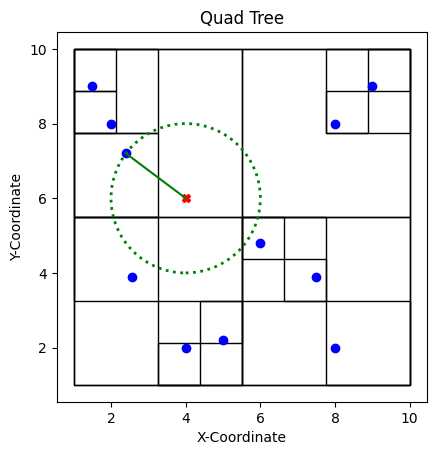

In [85]:
quad_tree = QuadTree(1.0, 10.0, 1.0, 10.0)
quad_tree.QuadTreeInsert(1.5, 9.0)
quad_tree.QuadTreeInsert(2.0, 8.0)
quad_tree.QuadTreeInsert(2.4, 7.2)
quad_tree.QuadTreeInsert(2.55, 3.9)
quad_tree.QuadTreeInsert(4.0, 2.0)
quad_tree.QuadTreeInsert(5.0, 2.2)
quad_tree.QuadTreeInsert(6.0, 4.8)
quad_tree.QuadTreeInsert(7.5, 3.9)
quad_tree.QuadTreeInsert(8.0, 2.0)
quad_tree.QuadTreeInsert(8.0, 8.0)
quad_tree.QuadTreeInsert(9.0, 9.0)

visualize_quad_tree(quad_tree, Point(4, 6))

Here we remove the point indicated previously as nearest neighbor for our targer point. The tree collapses its children nodes as needed and a new closest neighbor is identified.

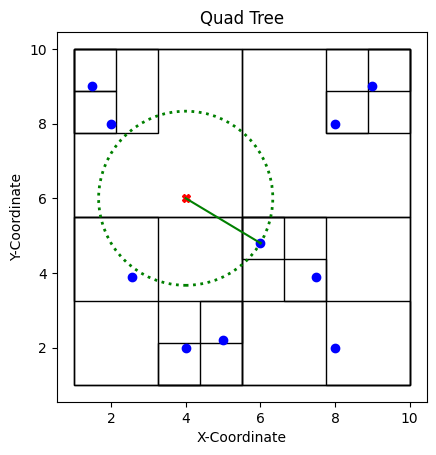

In [86]:
quad_tree.QuadTreeDelete(2.4, 7.2)
visualize_quad_tree(quad_tree, Point(4,6))

Just another example with removing a point from the quad tree and the rearranging of its children.

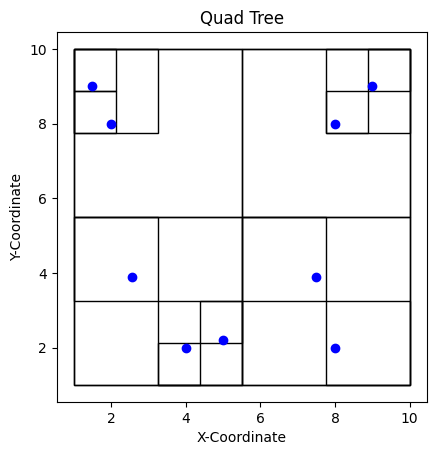

In [87]:
quad_tree.QuadTreeDelete(6.0, 4.8)
visualize_quad_tree(quad_tree)

# k-d Trees

A few additional helper functions for k-d Trees:
*   ComputeBoundingBox: compute the bounding box for a set of points
*   kd_euclidean_dist: calculates the euclidean distance for between two d-dimensional points



In [88]:
def ComputeBoundingBox(pts: List[List]) -> Tuple[List, List]:
    '''
    Helper function to compute the bounding boxes from a set of points represented as arrays
    '''
    # Extract the number of points and number of dimensions from the input data.
    num_points = len(pts)
    if num_points == 0:
        return None # Error
    num_dims = len(pts[0])

    # Create two lists, L and H to hold the low and high bounds.
    L = [None] * num_dims
    H = [None] * num_dims

    # Seed the L and H lists with the coordinates of the first point in our input data.
    for d in range(num_dims):
        L[d] = pts[0][d]
        H[d] = pts[0][d]

    # Iterate through the remaining points in the input data and check
    # if any of them falls outside the bounds and if so, extend the bounds.
    for i in range(1, num_points):
        for d in range(num_dims):
            if L[d] > pts[i][d]:
                L[d] = pts[i][d]
            if H[d] < pts[i][d]:
                H[d] = pts[i][d]

    return (L, H)

def kd_euclidean_dist(pt1: List, pt2: List) -> float:
    if len(pt1) != len(pt2):
        return None
    dist = 0.0
    for d in range(len(pt1)):
        dist += (pt1[d] - pt2[d]) ** 2
    return sqrt(dist)

A KDTreeNode class used to represent a node in a k-d Tree. Each node keeps the same number of dimensions as the k-d tree. A node can be an internal node or a leaf node. An internal node has two childrens (left and right) that split the points along a chosen split dimension (split_dim) based on a split value (split_val) where all points in left are <= split_val on the chosen split_dim and all points in right are > split_val on the chosen split_dim.
A leaf node has no more childrens but instead keeps a list of all the points.
Each node has a boundary box represented by x_min and x_max values for all d dimensions and every point contained by the node (and its children) is contained by this bounding box.

In [89]:
class KDTreeNode:
    def __init__(self, num_dimensions: int):
        self.is_leaf = True
        self.num_dimensions = num_dimensions
        self.num_points = 0
        self.x_min = [float('-Inf')] * num_dimensions
        self.x_max = [float('Inf')] * num_dimensions
        self.split_dim = -1
        self.split_val = 0.0
        self.left = None
        self.right = None
        self.points = []

    def RecursiveBuildKDTree(self, num_dims: int, pts: List[List]) -> None:
        '''
        Recursively partition the pts among the child nodes until we reach
        the termination criteria.
        '''
        # Start by initializing the node.
        self.num_points = len(pts)
        self.num_dimensions = num_dims
        self.left = None
        self.right = None
        self.points = []
        self.split_dim = -1
        self.split_val = 0.0
        self.is_leaf = True

        # Compute the bounding box of points.
        self.x_min, self.x_max = ComputeBoundingBox(pts)

        # Compute the width of the widest dimension (this will be used as split).
        max_width = 0.0
        min_width = float('Inf')
        split_dim = 0
        for d in range(self.num_dimensions):
            if self.x_max[d] - self.x_min[d] > max_width:
                max_width = self.x_max[d] - self.x_min[d]
                split_dim = d
            min_width = min(min_width, self.x_max[d] - self.x_min[d])

        # If we meet the conditions for a leaf append the remaining points
        # to the node's point list.
        # For simplification in this case we just look
        # at the min number of points to be 2 or min_width is less than 1
        if self.num_points <= 2 or min_width <= 1.0:
            for pt in pts:
                self.points.append(pt)
            return

        # Choose split dimension and value.
        # In this case we split along the middle of the widest dimension
        self.split_dim = split_dim
        self.split_val = (self.x_min[self.split_dim] + self.x_max[self.split_dim]) / 2

        # One other option would be to use the median of the values along
        # the widest dimenstion as seen below.
        # self.split_val = np.median(np.array(pts)[:, split_dim])

        self.is_leaf = False

        # Partition the points into two sets based on the split dimension and value.
        left_pts = []
        right_pts = []
        for pt in pts:
            if pt[self.split_dim] <= self.split_val:
                left_pts.append(pt)
            else:
                right_pts.append(pt)

        # Recursively build the child nodes.
        self.left = KDTreeNode(num_dims)
        self.left.RecursiveBuildKDTree(num_dims, left_pts)

        self.right = KDTreeNode(num_dims)
        self.right.RecursiveBuildKDTree(num_dims, right_pts)

    def KDTreeNodeInsert(self, pt: List) -> None:
        '''
        Insert a point into the k-d tree node by using split_dim and split_val
        to determine which branch to take. Split leaf nodes if they meet the
        split condition.
        Also update the bounding box to account for the new point.
        '''
        self.num_points += 1

        # Update the bounding box
        for d in range(self.num_dimensions):
            if pt[d] < self.x_min[d]:
                self.x_min[d] = pt[d]
            if pt[d] > self.x_max[d]:
                self.x_max[d] = pt[d]

        if not self.is_leaf:
            if pt[self.split_dim] <= self.split_val:
                self.left.KDTreeNodeInsert(pt)
            else:
                self.right.KDTreeNodeInsert(pt)
        else:
            self.points.append(pt)
            # Compute the width of the widest dimension (this will be used as split).
            max_width = 0.0
            min_width = float('Inf')
            split_dim = 0
            for d in range(self.num_dimensions):
                if self.x_max[d] - self.x_min[d] > max_width:
                    max_width = self.x_max[d] - self.x_min[d]
                    split_dim = d
                min_width = min(min_width, self.x_max[d] - self.x_min[d])

            # Check if we meet the conditions for a split.
            if len(self.points) > 3 and min_width > 1.0:
                self.split_dim = split_dim
                self.split_val = (self.x_min[self.split_dim] + self.x_max[self.split_dim]) / 2
                self.is_leaf = False

                # Partition left and right same as with build function (code repeated just to make it easier to understand)
                left_pts = [item for item in self.points if item[self.split_dim] <= self.split_val]
                right_pts = [item for item in self.points if item[self.split_dim] > self.split_val]
                self.left = KDTreeNode(self.num_dimensions)
                self.left.RecursiveBuildKDTree(self.num_dimensions, left_pts)
                self.right = KDTreeNode(self.num_dimensions)
                self.right.RecursiveBuildKDTree(self.num_dimensions, right_pts)

    def KDTreeNodeDelete(self, pt: List) -> bool:
        '''
        TODO
        '''
        pass

    def KDTreeNodeMinDist(self, pt: List) -> float:
        dist_sum = 0.0
        for d in range(self.num_dimensions):
            diff = 0.0
            if pt[d] < self.x_min[d]:
                diff = self.x_min[d] - pt[d]
            if pt[d] > self.x_max[d]:
                diff = pt[d] - self.x_max[d]
            dist_sum += diff ** 2

        return sqrt(dist_sum)

    def KDTreeNodeNearestNeighbor(self, pt: List, best_dist: float) -> List:
        '''
        Searches recursively for the nearest neighbor of our <pt> input data.
        best_dist represents the best distance so far is used for pruning logic.
        Returns a point from the tree node that is closer than best_dist or
        None otherwise.
        '''
        # Prune if the node is too far away.
        if self.KDTreeNodeMinDist(pt) >= best_dist:
            return None

        best_candidate = None

        # If we are in a leaf just search in the list of points.
        if self.is_leaf:
            for current in self.points:
                dist = kd_euclidean_dist(current, pt)
                if dist < best_dist:
                    best_dist = dist
                    best_candidate = current
            return best_candidate

        # Explore all childrens starting with the closest one based on split value.
        first = self.left if pt[self.split_dim] <= self.split_val else self.right
        second = self.right if first == self.left else self.left

        for child in (first, second):
            child_best = child.KDTreeNodeNearestNeighbor(pt, best_dist)
            # We have found a closer point so update best_candidate and best_dist.
            if child_best != None:
                best_candidate = child_best
                best_dist = kd_euclidean_dist(pt, child_best)

        return best_candidate





A KDTree class representing a k-d tree. Each k-d tree holds the number of dimensions it can support and every node contained is bound by this condition. A tree contains a root node.

In [90]:
class KDTree:
    def __init__(self, num_dimensions: int):
        self.num_dimensions = num_dimensions
        self.root = KDTreeNode(num_dimensions)

    def BuildKDTree(self, pts: List[List]) -> bool:
        '''
        Builds a k-d Tree by using a recursive process, starting with all data
        points and dividing them into two subsets by picking a splitting dimension
        and value.
        The process repeats at each level until we hit the termination criteria:
        - minimum number of points left at the node
        - minimum width
        - max depth
        '''
        # First check that all points have the correct dimensionality.
        for pt in pts:
            if len(pt) != self.num_dimensions:
                return False
        # Check that there are points to build a tree and start with the root.
        if len(pts) > 0:
            self.root = KDTreeNode(self.num_dimensions)
            self.root.RecursiveBuildKDTree(self.num_dimensions, pts)
        else:
            self.root = None
        return True

    def KDTreeInsert(self, pt: List) -> bool:
        '''
        Inserts a point inside the k-d Tree and returns True if it success.
        '''
        # Check that the inserted point has the correct number of dimensions.
        if len(pt) != self.num_dimensions:
            return False
        if self.root == None:
            self.root = KDTreeNode(self.num_dimensions)
        self.root.KDTreeNodeInsert(pt)
        return True

    def KDTreeDelete(self, pt: List) -> bool:
        '''
        TODO
        '''
        pass

    def KDTreeNearestNeighbor(self, pt: List) -> List:
        '''
        Returns the nearest neighbor in the k-d tree for our target pt.
        '''
        # Check that the targer point has the correct number of dimensions.
        if len(pt) != self.num_dimensions:
            return None
        if self.root == None:
            return None
        return self.root.KDTreeNodeNearestNeighbor(pt, float('Inf'))

Helper function to draw the k-d tree. Only works for a 2 dimensional tree. The function will draw rectangles with the bounding boxes for each node and a red dotted line for the split of internal nodes.
An optional target point can be passed which will be drawn as a cyan X together with a line towards the nearest neighbor found in the k-d tree.

In [91]:
def visualize_kd_tree(kd_tree: KDTree, target_pt: List=None) -> None:
    if kd_tree.num_dimensions > 2:
        return

    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.set_title('k-d tree')

    def draw_helper(node: KDTreeNode, ax):
        if node is None:
            return

        # Draw the bounding box of the node as a rectangle
        ax.add_patch(plt.Rectangle(xy=(node.x_min[0], node.x_min[1]), width=node.x_max[0] - node.x_min[0], height=node.x_max[1] - node.x_min[1], color='black', fill=False))
        if node.is_leaf:
            # If it's a leaf then scatter the points contained within.
            array = np.array(node.points)
            ax.scatter(array[:, 0], array[:, 1], c='blue')
        else:
            # If it's an internal node then draw the split line and continue the draw recursively with its children.
            if node.split_dim == 0:
                ax.plot([node.split_val, node.split_val], [node.x_min[1], node.x_max[1]], color='red', linestyle='--')
            else:
                ax.plot([node.x_min[0], node.x_max[0]], [node.split_val, node.split_val], color='red', linestyle='--')
            draw_helper(node.left, ax)
            draw_helper(node.right, ax)

    draw_helper(kd_tree.root, ax)

    if target_pt != None and len(target_pt) == kd_tree.num_dimensions:
        ax.plot(target_pt[0], target_pt[1], color='cyan', marker='X')
        closest_pt = kd_tree.KDTreeNearestNeighbor(target_pt)
        if closest_pt != None:
            ax.plot([target_pt[0], closest_pt[0]], [target_pt[1], closest_pt[1]], color='green', linestyle='-')
            circle = Circle((target_pt[0], target_pt[1]),
                            kd_euclidean_dist(target_pt, closest_pt),
                            linestyle=':', fill=False, linewidth=2, color='green')
            ax.add_patch(circle)

    plt.show()

Here we create a k-d tree with 11 points (similar with the quad tree example above) and then draw it. Also use a similar target point and a visual indicator to its nearest neighbor.

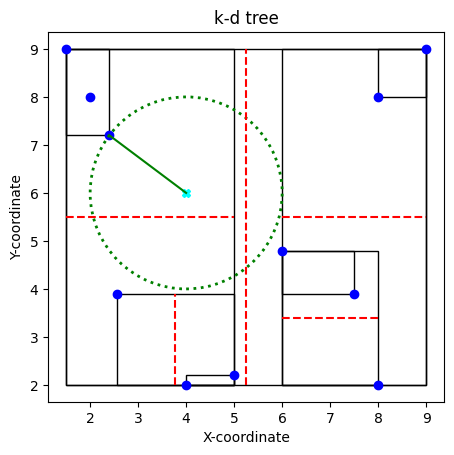

In [92]:
pts = [[1.5, 9.0], [2.0, 8.0], [2.4, 7.2], [2.55, 3.9], [4.0, 2.0], [5.0, 2.2], [6.0, 4.8], [7.5, 3.9], [8.0, 2.0], [8.0, 8.0], [9.0, 9.0]]
kdtree = KDTree(2)
kdtree.BuildKDTree(pts)
visualize_kd_tree(kdtree, [4, 6])

Insert a new point (closer to target) into the k-d tree and redraw it with the same target point.

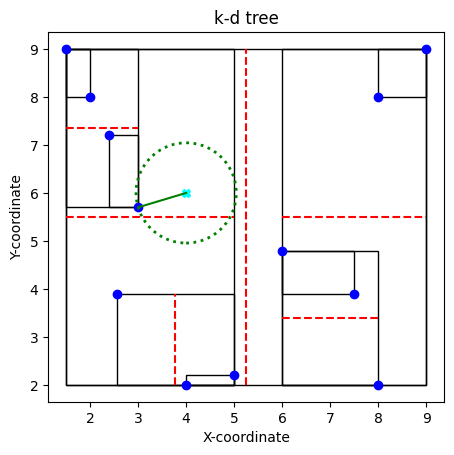

In [93]:
kdtree.KDTreeInsert([3, 5.7])
visualize_kd_tree(kdtree, [4, 6])